# Part 2

Reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

**Goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('white')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# h2 : updated house data
house = pd.read_csv('h2.csv')
#house.info()

Text(0.5,1,u'Identifying Price Drivers')

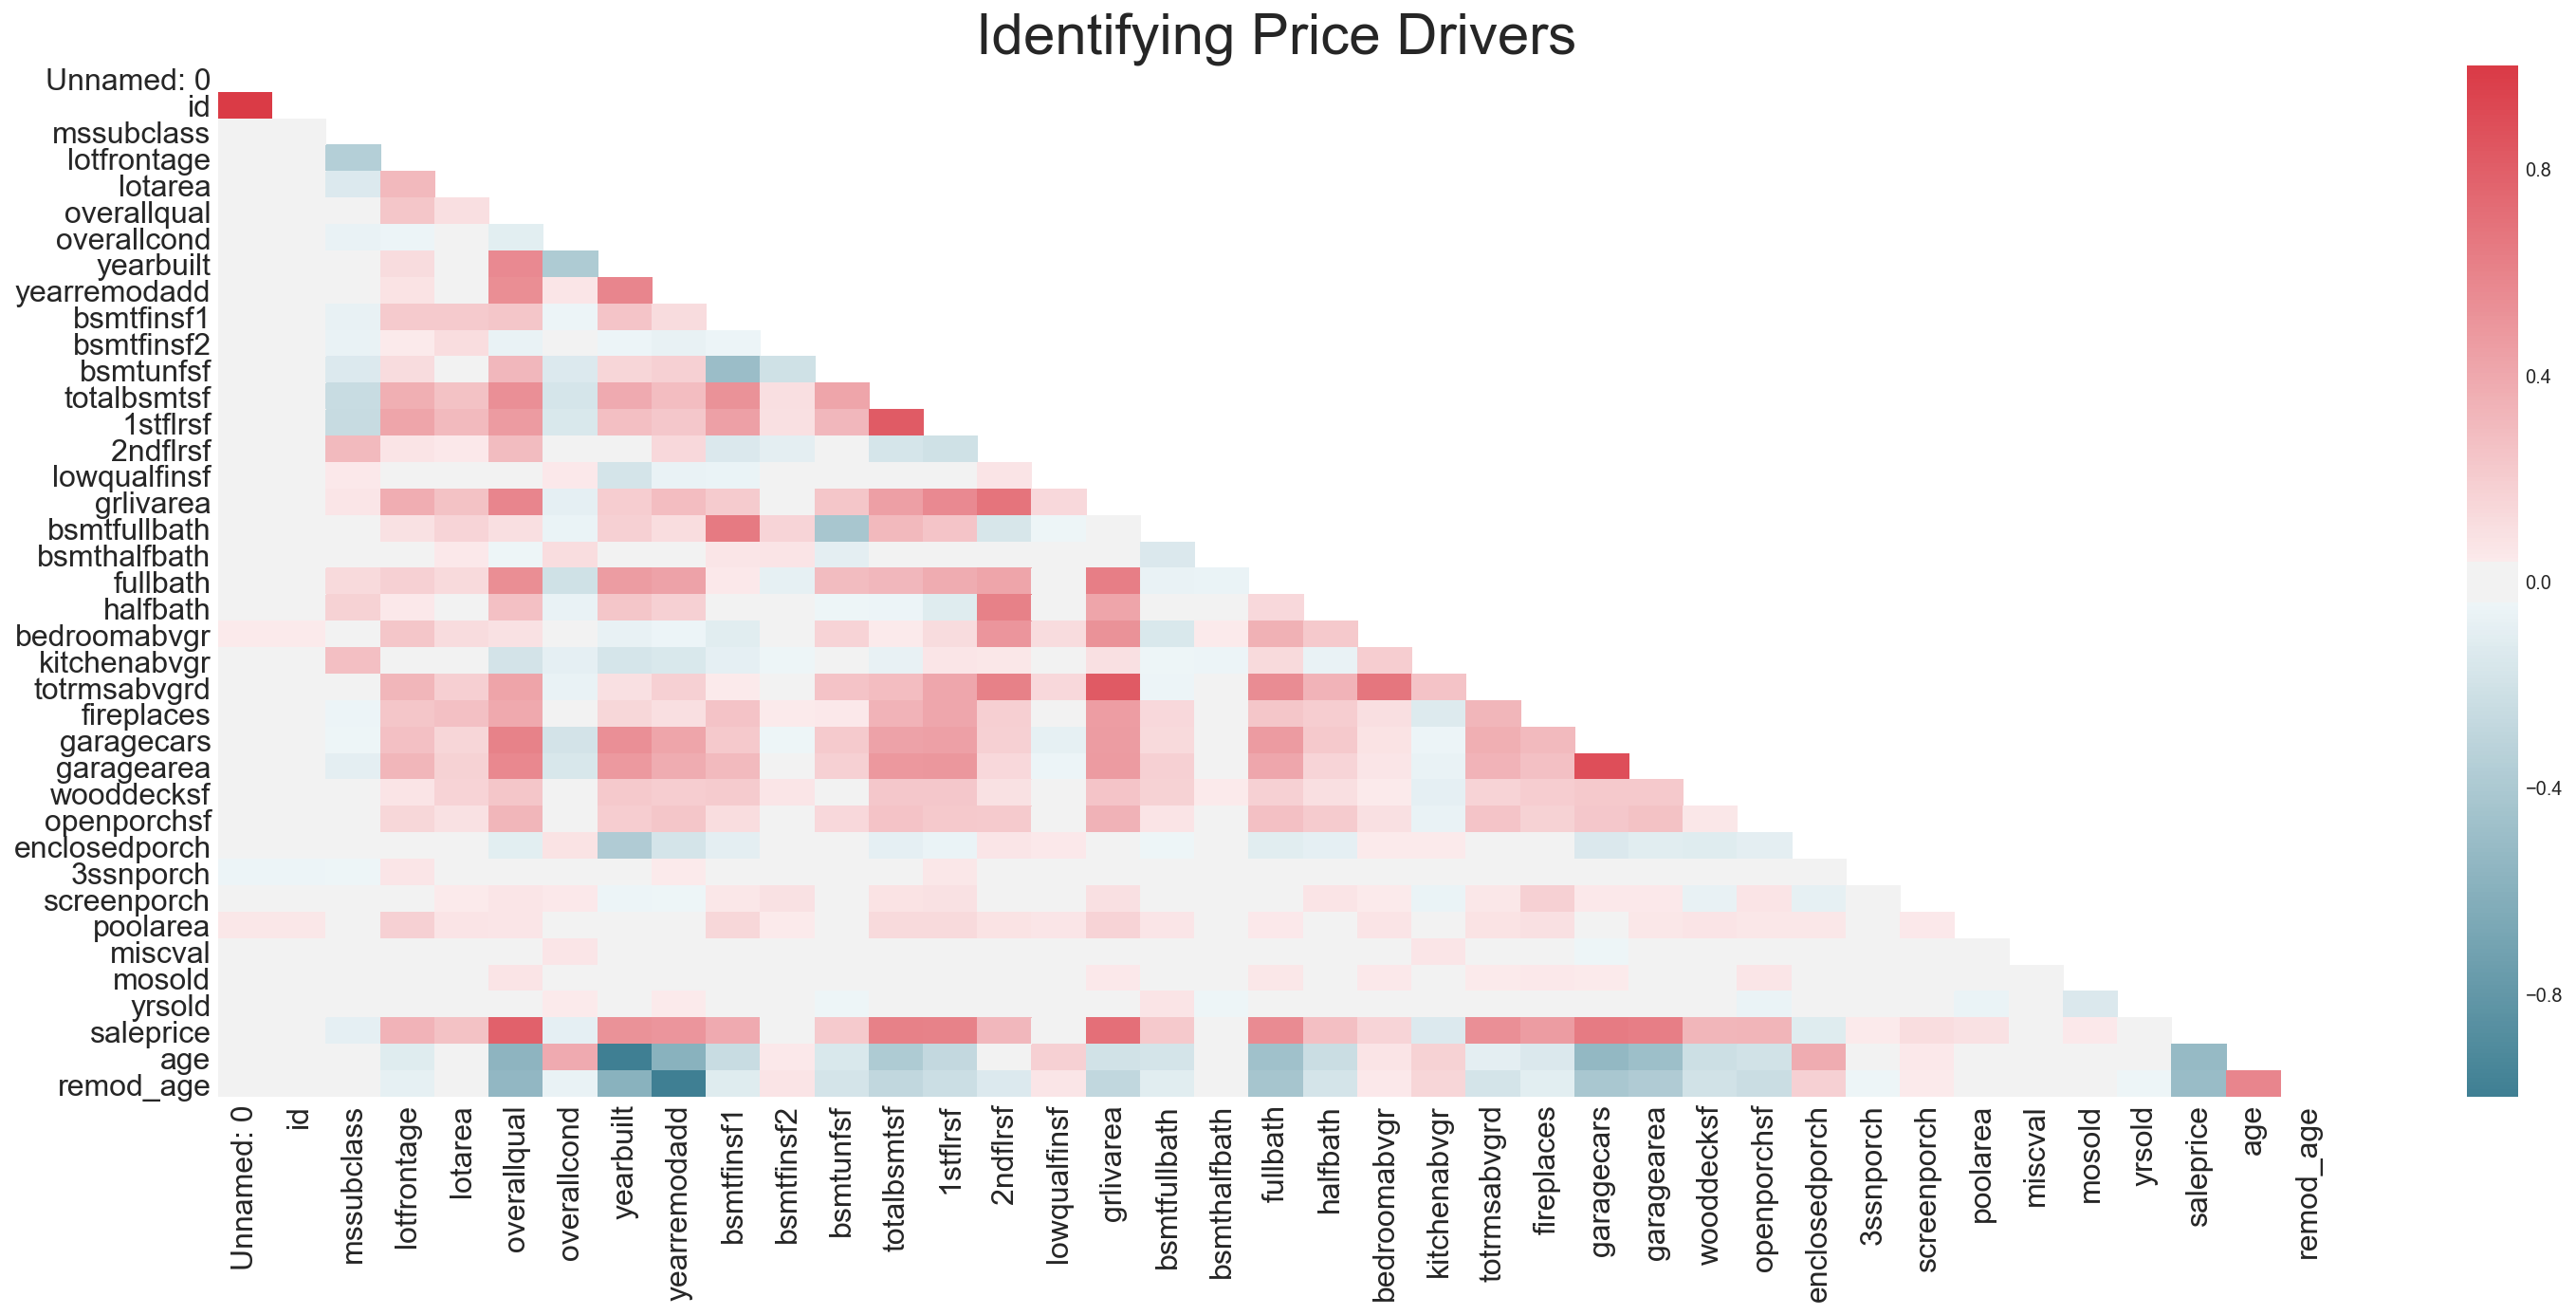

In [2]:
fig,ax=plt.subplots(figsize=(25,10))
cmap=sns.diverging_palette(220,10, as_cmap=True)

house_corr=house.corr()
mask=np.zeros_like(house_corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plot_a = sns.heatmap(house_corr, mask = mask, ax=ax, cmap=cmap)
plot_a.tick_params(labelsize = 16)
plot_a.set_title('Identifying Price Drivers', fontsize=30)

## Selecting Fixed Features

|Predictor   |Description   |   
|---|
| lotfrontage  | linear feet of street connected to property  |   
|  lotarea | lot size in sq ft  |   |   |   |
| lotconfig  | lot config  |   |   |   |
|neighborhood |physical location |
|bldgtype | type of dwelling |
|housestyle |style of dwelling
|bsmtqual | height of basement |
|totalbsmtsf | total sq ft of basement area |
|1stflrsf | |
|2ndflrsf | |
| grlivarea |above grade ground living area sq ft|
|fullbath  | |
|bedroomabvgr | |
| kitchenabvgr | |
| totrmsabvgrd | |
| fireplaces | |
|garagearea | **garagecars** removed, as garagearea and garagecars are highly correlated |
|wooddecksf | |
|openporchsf | |
|enclosedporchsf | |
|poolarea | |
|age |Calculated proxy for yearbuilt |
|remod_age |Calculated proxy for yearremodadd |
| | |



In [3]:
# filter for train dataset
#house = house[(house['yrsold'] != 2010)]
#house['yrsold'].unique()

In [4]:
# drop multiple columns
house.drop(['Unnamed: 0','mssubclass', 'mszoning','street','lotshape','landcontour','utilities','landslope','condition1','condition2',
            'overallqual','overallcond','yearbuilt','yearremodadd','roofstyle','roofmatl','exterior1st','exterior2nd',
            'exterqual','extercond','foundation','bsmtcond','bsmtexposure','bsmtfintype1','bsmtfinsf1','bsmtfintype2',
            'bsmtfinsf2','bsmtunfsf','heating','heatingqc','centralair','electrical','lowqualfinsf','bsmtfullbath',
            'bsmthalfbath','halfbath','kitchenqual','functional','fireplacequ', u'garagetype','garagefinish','garagecars',
            'garagequal','garagecond','paveddrive','3ssnporch','screenporch','poolqc','fence','miscfeature','miscval',
            'mosold','saletype','salecondition'],axis=1, inplace=True)


In [5]:
house.columns

Index([u'id', u'lotfrontage', u'lotarea', u'lotconfig', u'neighborhood',
       u'bldgtype', u'housestyle', u'bsmtqual', u'totalbsmtsf', u'1stflrsf',
       u'2ndflrsf', u'grlivarea', u'fullbath', u'bedroomabvgr',
       u'kitchenabvgr', u'totrmsabvgrd', u'fireplaces', u'garagearea',
       u'wooddecksf', u'openporchsf', u'enclosedporch', u'poolarea', u'yrsold',
       u'saleprice', u'age', u'remod_age'],
      dtype='object')

In [6]:
print house['lotconfig'].unique()
print house['neighborhood'].unique()
print house['bldgtype'].unique()
print house['housestyle'].unique()
print house['bsmtqual'].unique()

['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
['Gd' 'TA' 'Ex' 'No' 'Fa']


In [7]:
obj_df = house.select_dtypes(include=['object']).copy()
obj_df.head(4)

,lotconfig,neighborhood,bldgtype,housestyle,bsmtqual
0,Inside,CollgCr,1Fam,2Story,Gd
1,FR2,Veenker,1Fam,1Story,Gd
2,Inside,CollgCr,1Fam,2Story,Gd
3,Corner,Crawfor,1Fam,2Story,TA


In [8]:
dummy = pd.get_dummies(obj_df, columns=['lotconfig','neighborhood','bldgtype','housestyle','bsmtqual'], 
               prefix =['lotconfig','neighbor','bldgtype','housestyle','bsmt'])
dummy.head(2)

,lotconfig_Corner,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,neighbor_Blmngtn,neighbor_Blueste,neighbor_BrDale,neighbor_BrkSide,neighbor_ClearCr,...,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,bsmt_Ex,bsmt_Fa,bsmt_Gd,bsmt_No,bsmt_TA
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
house = pd.concat([house,dummy],axis=1)
house.head(2)

,id,lotfrontage,lotarea,lotconfig,neighborhood,bldgtype,housestyle,bsmtqual,totalbsmtsf,1stflrsf,...,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,bsmt_Ex,bsmt_Fa,bsmt_Gd,bsmt_No,bsmt_TA
0,1,65.0,8450,Inside,CollgCr,1Fam,2Story,Gd,856,856,...,0,0,1,0,0,0,0,1,0,0
1,2,80.0,9600,FR2,Veenker,1Fam,1Story,Gd,1262,1262,...,0,0,0,0,0,0,0,1,0,0


In [10]:
house.drop(['lotconfig','neighborhood','bldgtype','housestyle','bsmtqual'],axis=1, inplace=True)

In [11]:
house_train = house[house.yrsold != 2010]

In [12]:
X = house_train[['lotfrontage', 'lotarea', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'grlivarea', 'fullbath', 'bedroomabvgr',
       'kitchenabvgr','totrmsabvgrd','fireplaces','garagearea','wooddecksf', 'openporchsf', 'enclosedporch', 'poolarea',
       'age', 'remod_age', 'lotconfig_Corner', 'lotconfig_CulDSac', 'lotconfig_FR2', 'lotconfig_FR3',
       'lotconfig_Inside', 'neighbor_Blmngtn', 'neighbor_Blueste','neighbor_BrDale', 'neighbor_BrkSide', 'neighbor_ClearCr',
       'neighbor_CollgCr', 'neighbor_Crawfor', 'neighbor_Edwards', 'neighbor_Gilbert', 'neighbor_IDOTRR', 'neighbor_MeadowV',
       'neighbor_Mitchel', 'neighbor_NAmes', 'neighbor_NPkVill','neighbor_NWAmes', 'neighbor_NoRidge', 'neighbor_NridgHt',
       'neighbor_OldTown', 'neighbor_SWISU', 'neighbor_Sawyer','neighbor_SawyerW', 'neighbor_Somerst', 'neighbor_StoneBr',
       'neighbor_Timber', 'neighbor_Veenker', 'bldgtype_1Fam','bldgtype_2fmCon', 'bldgtype_Duplex', 'bldgtype_Twnhs',
       'bldgtype_TwnhsE', 'housestyle_1.5Fin', 'housestyle_1.5Unf','housestyle_1Story', 'housestyle_2.5Fin', 
       'housestyle_2.5Unf','housestyle_2Story', 'housestyle_SFoyer', 'housestyle_SLvl',
       'bsmt_Ex', 'bsmt_Fa', 'bsmt_Gd', 'bsmt_No', 'bsmt_TA']].values
y = house_train['saleprice']


In [13]:
import patsy
#formula = 'y ~ X'
#y,X = patsy.dmatrices(formula, data=house, return_type='dataframe')

score 0.836575807402 

RMSE_train 31962.3255993


Text(0,0.5,u'Actual')

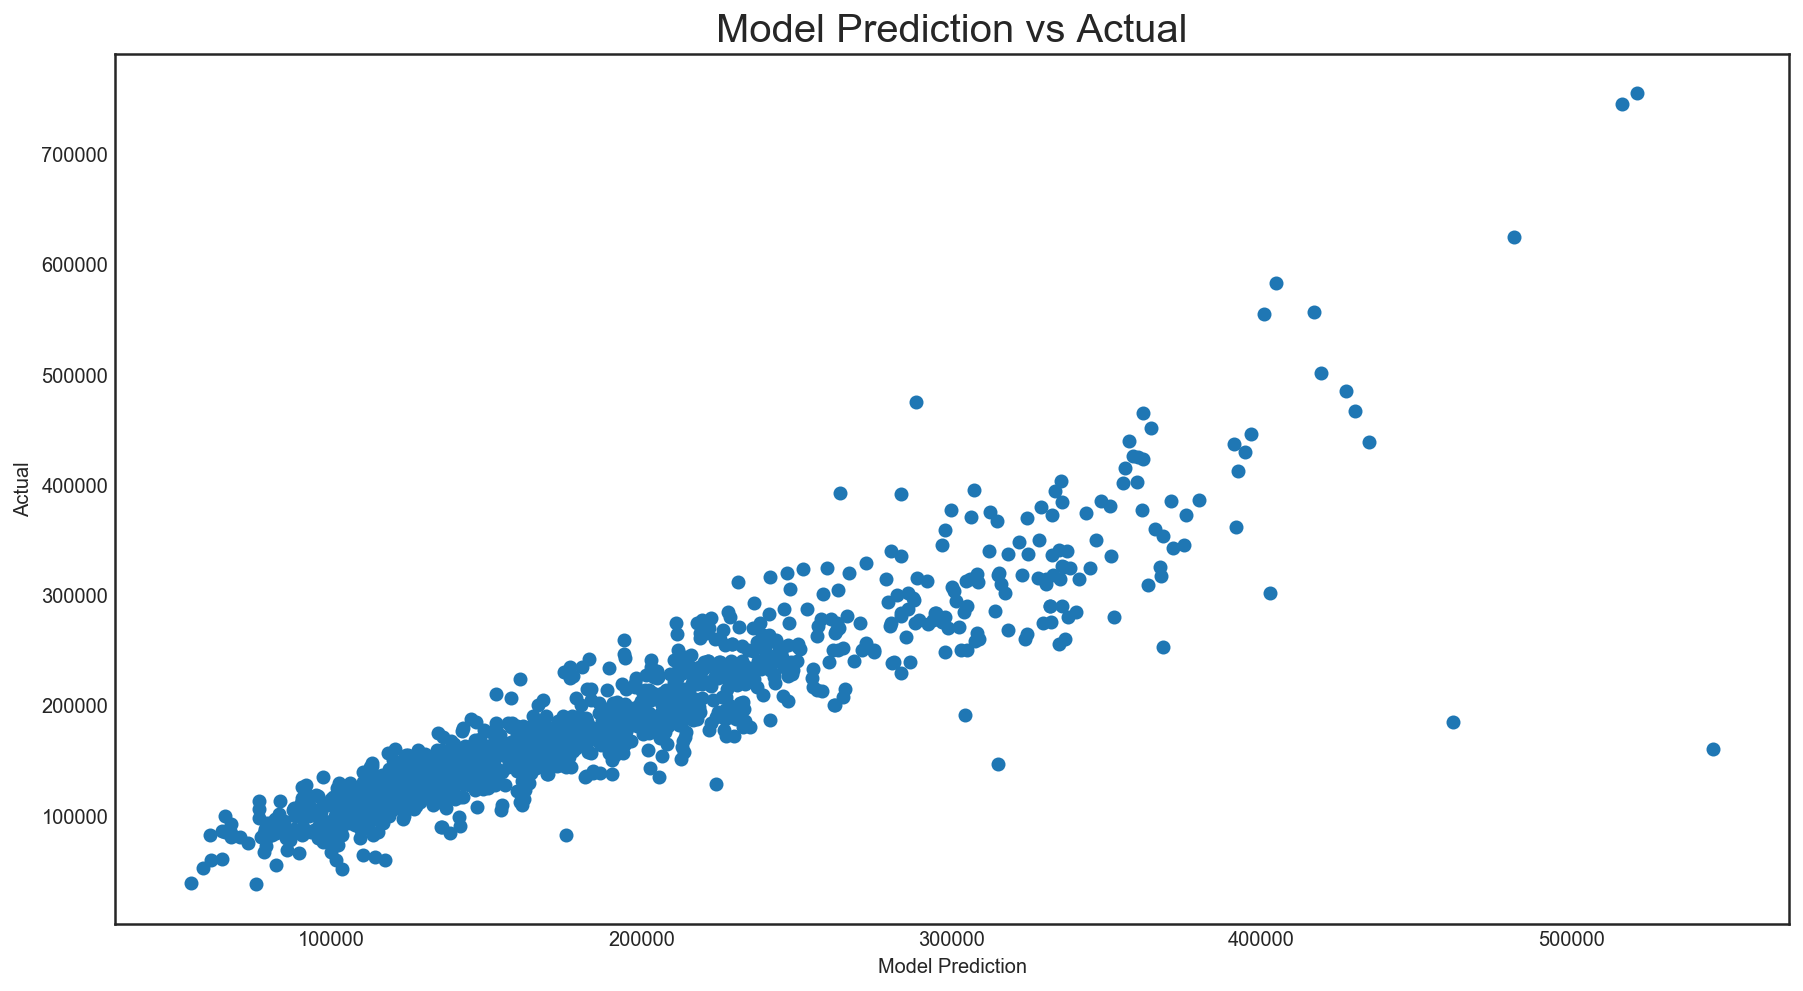

In [14]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

lm = linear_model.LinearRegression()
model = lm.fit(X,y)

model_coef = model.coef_
predict = model.predict(X)
score = model.score(X,y)
RMSE_train = (mean_squared_error(y, predict))**0.5

print 'score', score,'\n'
print 'RMSE_train', RMSE_train

plt.figure(figsize=(15,8))
plt.scatter(predict, y)
plt.title('Model Prediction vs Actual', fontsize=20)
plt.xlabel ('Model Prediction')
plt.ylabel ('Actual')

In [15]:
X_col = ['lotfrontage', 'lotarea', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'grlivarea', 'fullbath', 'bedroomabvgr',
       'kitchenabvgr','totrmsabvgrd','fireplaces','garagearea','wooddecksf', 'openporchsf', 'enclosedporch', 'poolarea',
       'age', 'remod_age', 'lotconfig_Corner', 'lotconfig_CulDSac', 'lotconfig_FR2', 'lotconfig_FR3',
       'lotconfig_Inside', 'neighbor_Blmngtn', 'neighbor_Blueste','neighbor_BrDale', 'neighbor_BrkSide', 'neighbor_ClearCr',
       'neighbor_CollgCr', 'neighbor_Crawfor', 'neighbor_Edwards', 'neighbor_Gilbert', 'neighbor_IDOTRR', 'neighbor_MeadowV',
       'neighbor_Mitchel', 'neighbor_NAmes', 'neighbor_NPkVill','neighbor_NWAmes', 'neighbor_NoRidge', 'neighbor_NridgHt',
       'neighbor_OldTown', 'neighbor_SWISU', 'neighbor_Sawyer','neighbor_SawyerW', 'neighbor_Somerst', 'neighbor_StoneBr',
       'neighbor_Timber', 'neighbor_Veenker', 'bldgtype_1Fam','bldgtype_2fmCon', 'bldgtype_Duplex', 'bldgtype_Twnhs',
       'bldgtype_TwnhsE', 'housestyle_1.5Fin', 'housestyle_1.5Unf','housestyle_1Story', 'housestyle_2.5Fin', 
       'housestyle_2.5Unf','housestyle_2Story', 'housestyle_SFoyer', 'housestyle_SLvl',
       'bsmt_Ex', 'bsmt_Fa', 'bsmt_Gd', 'bsmt_No', 'bsmt_TA']

model_coef = pd.DataFrame(zip(X_col,model.coef_),columns=['feature','coef']).sort_values(by=['coef'])
print 'Top 20 Model Drivers','\n','\n' 
print model_coef.tail(10),'\n'
print model_coef.head(10)

#model_coef.sort_values(by=['coef'])

Top 20 Model Drivers 


              feature          coef
50    bldgtype_Duplex  12288.833978
29   neighbor_Crawfor  14371.836589
44   neighbor_Somerst  15754.993456
59  housestyle_SFoyer  16463.029719
49    bldgtype_2fmCon  18146.698950
47   neighbor_Veenker  31482.733094
61            bsmt_Ex  43252.528556
39   neighbor_NridgHt  43965.615582
45   neighbor_StoneBr  60903.266165
38   neighbor_NoRidge  63739.630331 

              feature          coef
8        kitchenabvgr -32000.103155
30   neighbor_Edwards -27485.017897
51     bldgtype_Twnhs -25815.832041
34   neighbor_Mitchel -23400.124977
41     neighbor_SWISU -22996.152421
40   neighbor_OldTown -22533.423230
32    neighbor_IDOTRR -20121.261860
42    neighbor_Sawyer -19765.502372
56  housestyle_2.5Fin -17284.066437
33   neighbor_MeadowV -16068.479642


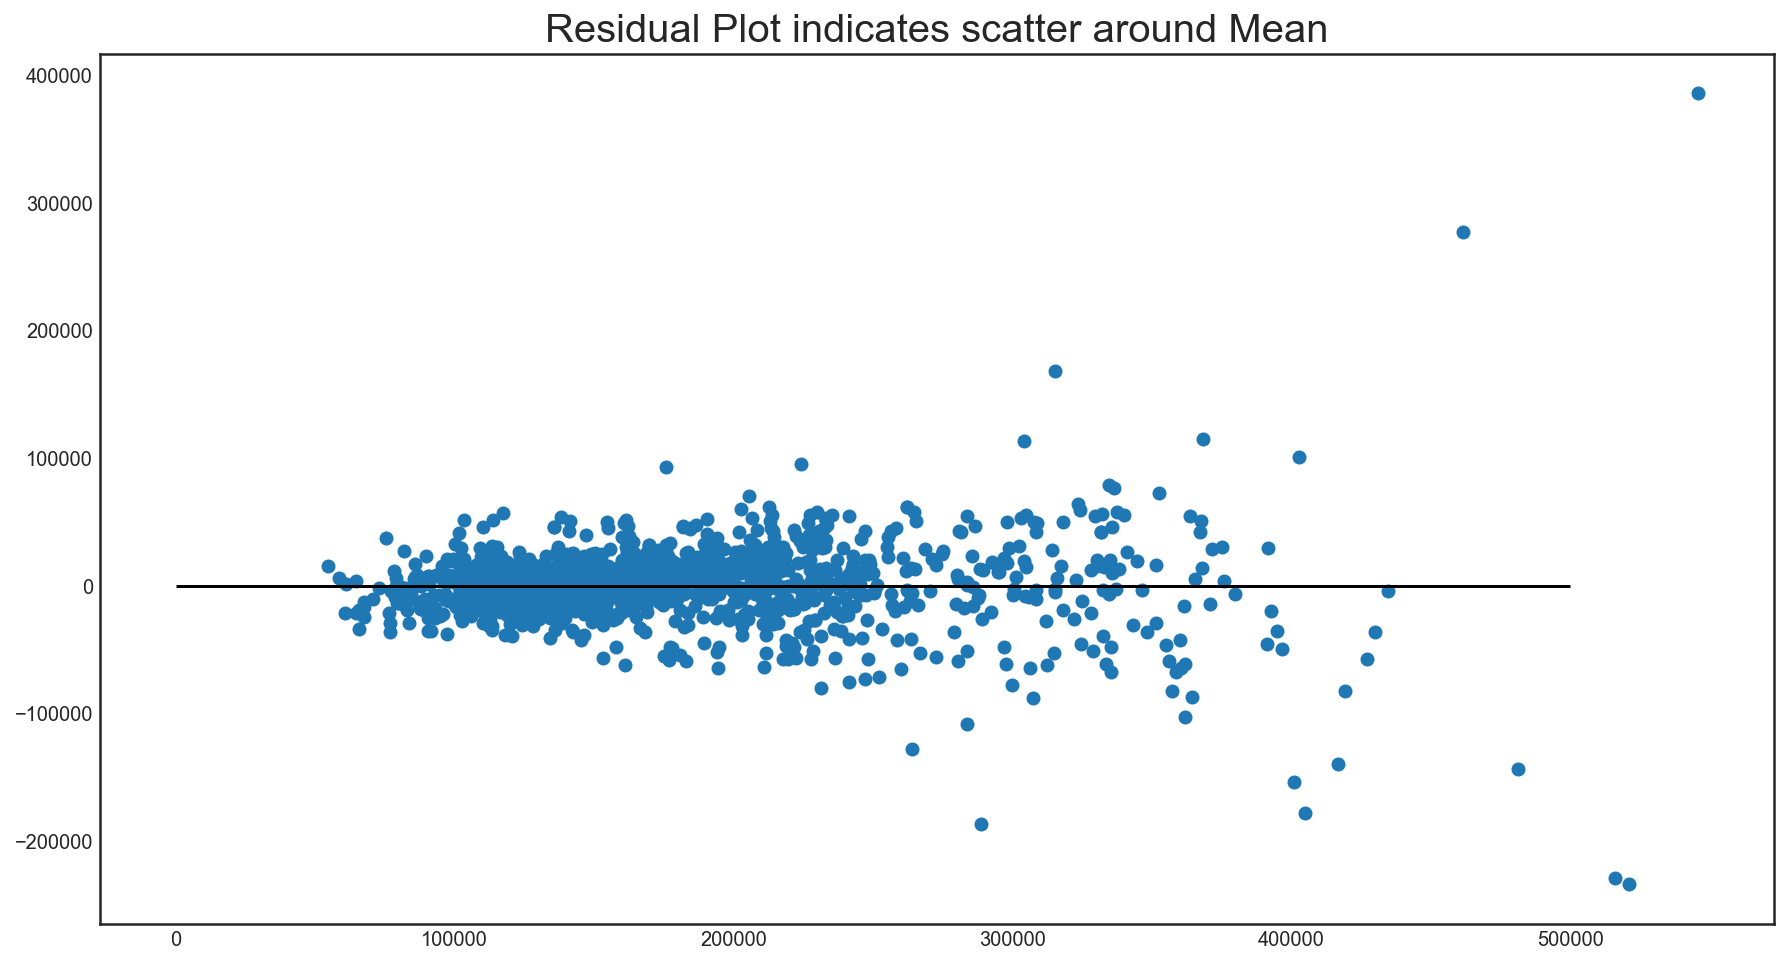

In [16]:
# Residual plot to check model
plt.figure(figsize=(15,8))
plt.title('Residual Plot indicates scatter around Mean', fontsize=20)
plt.scatter(model.predict(X),model.predict(X) - y)
plt.hlines(y=0, xmin=0,xmax= 500000)

In [17]:
# test model against 2010 data
house_test = house[house.yrsold == 2010]

X_test = house_test[['lotfrontage', 'lotarea', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'grlivarea', 'fullbath', 'bedroomabvgr',
       'kitchenabvgr','totrmsabvgrd','fireplaces','garagearea','wooddecksf', 'openporchsf', 'enclosedporch', 'poolarea',
       'age', 'remod_age', 'lotconfig_Corner', 'lotconfig_CulDSac', 'lotconfig_FR2', 'lotconfig_FR3',
       'lotconfig_Inside', 'neighbor_Blmngtn', 'neighbor_Blueste','neighbor_BrDale', 'neighbor_BrkSide', 'neighbor_ClearCr',
       'neighbor_CollgCr', 'neighbor_Crawfor', 'neighbor_Edwards', 'neighbor_Gilbert', 'neighbor_IDOTRR', 'neighbor_MeadowV',
       'neighbor_Mitchel', 'neighbor_NAmes', 'neighbor_NPkVill','neighbor_NWAmes', 'neighbor_NoRidge', 'neighbor_NridgHt',
       'neighbor_OldTown', 'neighbor_SWISU', 'neighbor_Sawyer','neighbor_SawyerW', 'neighbor_Somerst', 'neighbor_StoneBr',
       'neighbor_Timber', 'neighbor_Veenker', 'bldgtype_1Fam','bldgtype_2fmCon', 'bldgtype_Duplex', 'bldgtype_Twnhs',
       'bldgtype_TwnhsE', 'housestyle_1.5Fin', 'housestyle_1.5Unf','housestyle_1Story', 'housestyle_2.5Fin', 
       'housestyle_2.5Unf','housestyle_2Story', 'housestyle_SFoyer', 'housestyle_SLvl',
       'bsmt_Ex', 'bsmt_Fa', 'bsmt_Gd', 'bsmt_No', 'bsmt_TA']].values
y_test = house_test['saleprice']


In [24]:
y_test_predict = model.predict(X_test)

score_test = model.score(X_test,y_test)
RMSE_test = (mean_squared_error(y_test, y_test_predict))**0.5

print 'score', score_test,'\n'
print 'RMSE_test', RMSE_test

score 0.850871699236 

RMSE_test 30790.7149217


Text(0,0.5,u'Actual')

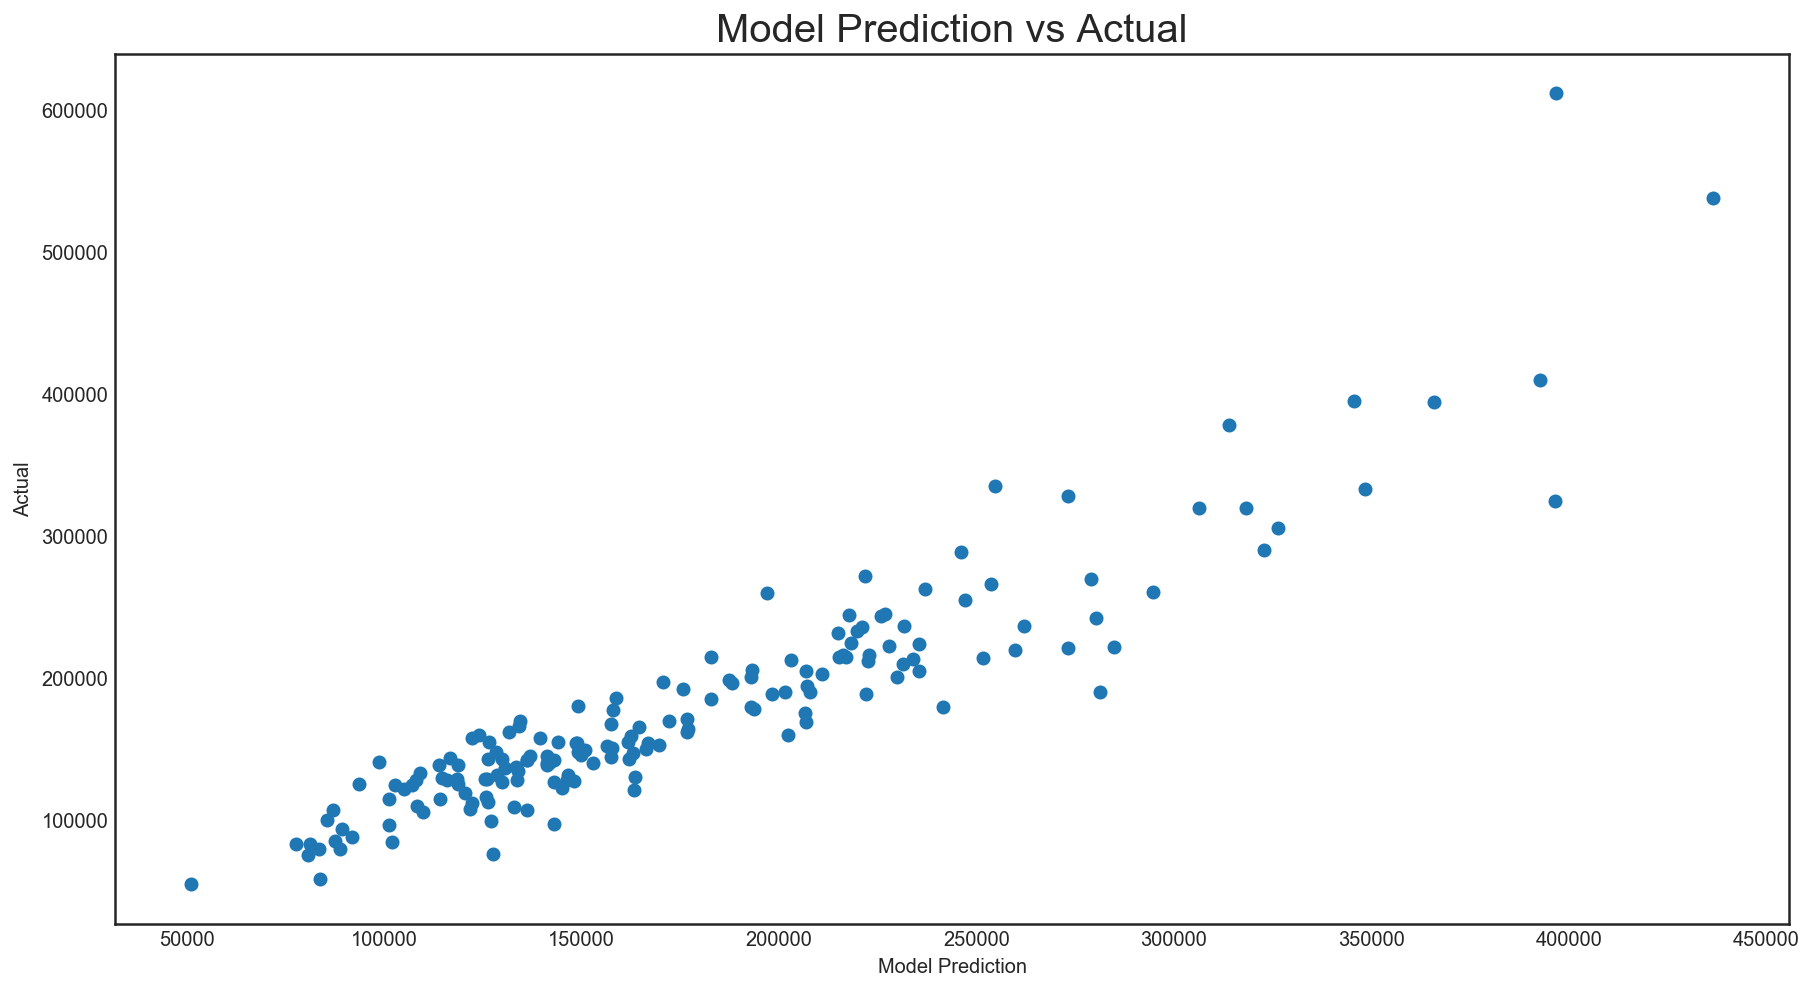

In [19]:
# 2010 data - predicted vs actual
plt.figure(figsize=(15,8))
plt.scatter(y_test_predict, y_test)
plt.title('Model Prediction vs Actual', fontsize=20)
plt.xlabel ('Model Prediction')
plt.ylabel ('Actual')

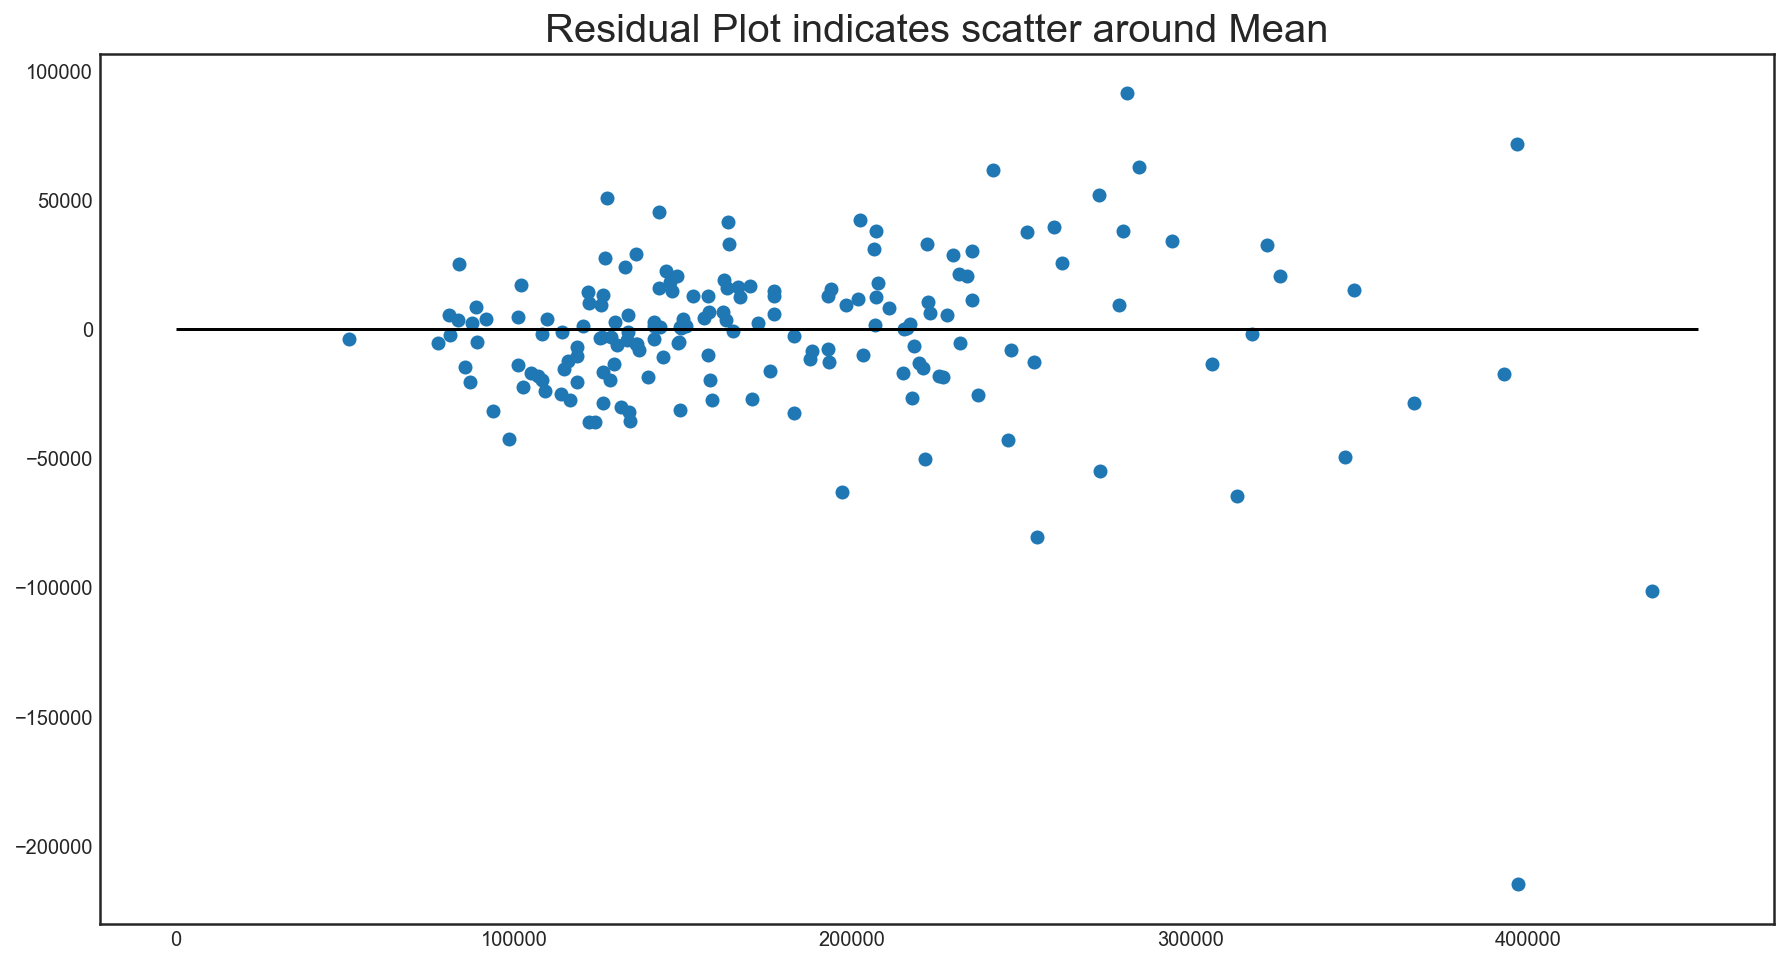

In [21]:
# Residual plot to check model
plt.figure(figsize=(15,8))
plt.title('Residual Plot indicates scatter around Mean', fontsize=20)
plt.scatter(model.predict(X_test),model.predict(X_test) - y_test)
plt.hlines(y=0, xmin=0,xmax= 450000)

## Commentary

The model looks reasonable with a R squared of **0.85** for the test data and **0.84** for the train data set.
Residual plot indicates that the model is not unusual with the points scattered around the mean.

The Model Prediction vs 2010 Actual does show that the model tends to overweight and as the salesprice increases, the 
accuracy decreases.

The impact of the US Housing crisis should be considered with respect to the model.

![Impact of the US Housing Crisis](https://en.wikipedia.org/wiki/United_States_housing_bubble#/media/File:Median_and_Average_Sales_Prices_of_New_Homes_Sold_in_the_US_1963-2010_Monthly.png) 



